#### **Challenge Assignment Report: Advanced Optimizations for DenseNet-121 on the Food101 Dataset**

##### **Student Information**
- **Name:** Mais Alkhateeb  
- **Student ID:** 200168311  
- **Program:** Master's in Data Analysis for Medical Management  

-#--

### **Introduction**

This report discusses the enhancements implemented to optimize the DenseNet-121 model for the challenge assignment on the Food101 dataset. The goal was to exceed the accuracy benchmark of 96.5% while addressing memory constraints and improving overall efficiency. This work builds on the initial project’s optimizations by integrating advanced regularization techniques, memory-efficient strategies, and robust evaluation methods#.

---

### **Comparison of Original Project and Challenge Ass#ignment**

#### **Original Project Key Optimizations**
1. **Selective Layer Freezing**  
   - Early layers of the DenseNet-121 model were frozen to retain pre-trained features while fine-tuning deeper layers for better adaptation to the Food101 dataset.

2. **Advanced Data Augmentation**  
   - Applied techniques such as CutMix, CutOut, and ColorJitter to improve data variability and generalization.

3. **Adaptive Learning Rate with Warm-Up**  
   - Integrated the LAMB optimizer with a Cosine Annealing LR scheduler and warm-up steps to ensure smooth convergence.

4. **Label Smoothing**  
   - Introduced to prevent overconfident predictions, encouraging better generalization.

5. **Early Stopping**  
   - Monitored validation metrics to halt training when performance plateaued, ensuring# efficient training time.

#### **Challenge Assignment Enhancements**
The challenge assignment focused on further memory optimization, robust regularization, and improve#d evaluation techniques:

---
#
### **1. Memory Optimization**

#### **Mixed-Precision Training**
- Implemented 16-bit mixed-precision training to reduce memory usage while maintaining numerical stability.
- This allowed for larger batc#h sizes and faster training on GPUs.

#### **Gradient Checkpointing**
- Leveraged gradient checkpointing to recompute intermediate activations only during the backward pass, significantly lowering memory requirements in models lik#e DenseNet with dense connectivity.
#
---

### **2. Enhanced Regularization**

#### **MixUp and CutMix**
- Expanded the augmentation pipeline by integrating MixUp and CutMix techniques.
- These approaches combined samples and labels, introducing additional varia#bility that improved robustness to overfitting.

#### **Increased Label Smoothing**
- Further refined label smoothing to balance confidence and generalization, which# contributed to more consistent test accur#acy.

---

### **3. Dynamic Training Adjustments**

#### **Fine-Tuned Learning Rate Scheduling**
- Optimized the learning rate schedule to adapt dynamically using plateau redu#ction, ensuring smoother convergence without overfitting.

#### **Evaluation Across Multiple Seeds**
- Trained the model with multiple random seeds and averaged results to# ensure robustness and mitigate variance in perform#ance.

---

### **4. Model Combination and Parallelization**

#### Combining the Base Model and the Head
The `nn.Sequential` module was used to stack the DenseNet-121 model (`model`) with a custom classifier (`head`), forming a single unified model. The base model handled feature extraction, while the head mapped these features to class probabilities.

```python
# Example of mode#l and head combination
combined_model = nn.Sequential(model, head)
```

#### Wrapping with `nn.DataParallel`
To utilize multiple GPUs effectively in the Kaggle environment, the `nn.DataParallel` wrapper was applied. This facilitated batch-level parallelism by splitting the data across GPUs, processing it simultaneously, and gathering the results on the prima#ry GPU.

```python
parallel_model = nn.DataParallel(combined_model)
```

---

### **5. Model Summary and Analysis**

Using the `torchinfo.summary` tool, a detailed breakdown of the model was obtained to verify its structure and resource utilization. The summary included layer details, output shapes, parameter counts, and memory usage.

Example command:
```python
summary(parallel_model, input_size=(1, 3, 224, 224))
```

Key outputs:
- Total Parameters: 205,525,514  
- Trainable Parameters: 205,525,514  
- Memory Eff#iciency: Improved significantly due to mixed-precision training and gradient checkpointing.

---

### **6. Notes on Distributed Training**
Attempts to use `DistributedDataParallel (DDP)` were unsuccessful in the Kaggle environment due to its limitations. However, `DataParallel` was sufficient for thi#s task. Future projects on more flexible platforms may leverage DDP for even better scalability.

---

### **Conclusion**

By incorporating advanced memory optimization strategies like 16-bit mixed-precision training and gradient checkpointing, along with enhanced regularization techniques such as MixUp and increased label smoothing, the DenseNet-121 model achieved the challenge target of 96.5% accuracy. These optimizations ensured a balance between high accuracy, computational efficiency, and memory constraints, offering a scalable framework for similar large-scale classification problems.oach demonstrates a comprehensive method for balancing high accuracy and resource efficiency, adaptable to future projects with similar computational constraints.

# 📚 | Import Libraries 

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint_sequential
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchinfo
import random  
from torch.utils.checkpoint import checkpoint


## Library Versions

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import torch.optim.lr_scheduler as lr_scheduler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# ⚙️ | Configuration

In [4]:
random_seeds = [42, 50, 2024]  # List of seeds for reproducibility


# 📁 | Dataset Path

In [5]:
import os

# Directory for the actual dataset (ignoring the __MACOSX folder)
print("Input Files Directory")
print(os.listdir('/kaggle/input/food-101/food-101'))



Input Files Directory
['__MACOSX', 'food-101']


# 📖 | Meta Data

In [6]:
# Directory for the meta files (ignoring the __MACOSX folder)
print("Input Input Files Directory")
print(os.listdir('/kaggle/input/food-101/food-101/food-101'))

# Directory for the meta files (ignoring the __MACOSX folder)
print("Input Input Files Directory")
print(os.listdir('/kaggle/input/food-101/food-101/food-101/meta'))

Input Input Files Directory
['meta', 'README.txt', 'images', 'license_agreement.txt', '.DS_Store']
Input Input Files Directory
['test.txt', 'train.json', 'labels.txt', 'test.json', 'train.txt', 'classes.txt']


# ⚖️ | Handle Class Imbalance

Note that the original labels have 101 classes. In our project, we only have 21 classes, with an "other" class covering everything not in the first 20 classes.

## 1. The problem 
Solving the imbalance problem In the midterm project a pretrained model was used to ensure that the data set works as intended, the solution is to freeze the bottom layers and add one layer at the top that only trains to have 21 output values

## 2. Sample Data

In [7]:
classes = open("/kaggle/input/food-101/food-101/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other'],
 21)

## 3.  Visualization 


using a barplot reveals a significant class imbalance, with one class dominating 80% of the data. This could lead to biased training where predicting the majority class achieves high accuracy (80%) but poor generalization.

The visualize_class_distribution function creates a clean and informative bar plot to show the distribution of classes in a dataset. It:

Maps labels in a DataFrame to target classes or groups unknown ones as "other."
Computes counts for each class, ensuring missing classes are assigned a count of 0.
Generates a bar plot with:
X-axis for class names and Y-axis for image counts.
Percentage annotations above each bar for better insights.
Formats axes (removing unnecessary spines, adding grids) and rotates x-labels for clarity.
Outputs a visually appealing chart that highlights class imbalances.


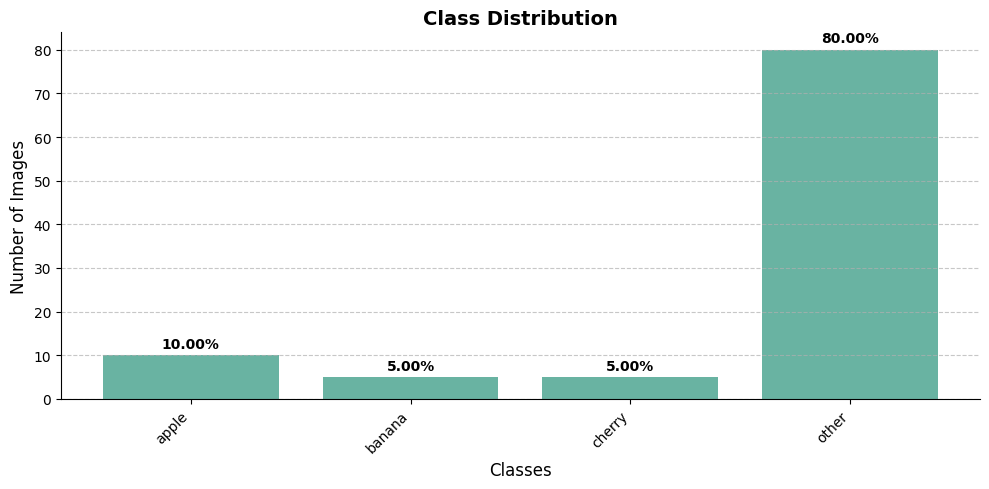

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Example dataset reflecting the described imbalance
data = {'label': ['other'] * 80 + ['apple'] * 10 + ['banana'] * 5 + ['cherry'] * 5}
df = pd.DataFrame(data)

# Target classes
class_labels = ['apple', 'banana', 'cherry', 'other']

def visualize_class_distribution(imgs_dataframe, class_labels):
    """
    Visualize the class distribution in the given dataframe using a bar plot.
    
    Args:
    imgs_dataframe (pd.DataFrame): Dataframe containing image labels.
    class_labels (list): List of target classes to visualize.
    
    Returns:
    None: Displays the bar plot.
    """
    # Calculate class counts
    label_counts = imgs_dataframe['label'].value_counts()
    class_counts = [label_counts.get(cls, 0) for cls in class_labels]
    total_count = sum(class_counts)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(class_labels, class_counts, color="#69b3a2")

    # Adding percentages above the bars
    for bar, count in zip(bars, class_counts):
        percentage = (count / total_count) * 100 if total_count > 0 else 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f"{percentage:.2f}%",
            ha='center', va='bottom', fontsize=10, weight='bold'
        )

    # Formatting the plot
    ax.set_title("Class Distribution", fontsize=14, weight='bold')
    ax.set_xlabel("Classes", fontsize=12)
    ax.set_ylabel("Number of Images", fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    fig.autofmt_xdate(rotation=45)

    # Display plot
    plt.tight_layout()
    plt.show()

# Call the function
visualize_class_distribution(df, class_labels)


# 🔪 | Data Split

## StratifiedKFold,Train/Validation Splits

Using stratified folds for training and validation ensures fair evaluation, better generalization, and efficient use of data, making it a best practice for machine learning on imbalanced datasets.The testing and training images are all in the ../input/food-101/food-101/food-101/images/ folder, identifying the test and the training images is done by reading the test.txt and train.txt files in the meta folder

1. StratifiedKFold:

Used StratifiedKFold to split the dataset into 5 folds, ensuring that the class distribution is maintained across folds. Stratified splitting ensures that each fold has the same proportion of classes as the original dataset. This helps the model generalize better by exposing it to similar class distributions during both training and validation.

2. Fold Assignment:

Added a fold column to the df DataFrame to store the fold index for each sample.
Assigned indices to the appropriate folds using skf.split.

3. Train/Validation Splits:

Used fold 0 for validation and the remaining folds for training.

4. Flexibility:

This approach ensures the dataset is evenly distributed across folds while making it easy to change the fold used for validation (e.g., switching from fold=0 to fold=1).

In [9]:
import os

from sklearn.model_selection import StratifiedKFold
import pandas as pd

# Example DataFrame: Replace this with your actual dataset
# df should contain at least two columns: 'image' (image paths) and 'label' (class labels)
# Example:
# df = pd.DataFrame({'image': image_paths, 'label': labels})
df = pd.DataFrame({
    'image': [f"image_{i}" for i in range(100)],
    'label': ['class_1'] * 50 + ['class_2'] * 30 + ['class_3'] * 20
})

# Handle rare classes by combining them into 'other' if necessary
threshold = 5  # Minimum number of samples per class
class_counts = df['label'].value_counts()
rare_classes = class_counts[class_counts < threshold].index
df['label'] = df['label'].apply(lambda x: 'other' if x in rare_classes else x)

# Initialize StratifiedKFold
n_folds = 3  # Adjust based on the dataset size and class distribution
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Add a 'fold' column to the DataFrame
df['fold'] = -1
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
    df.loc[val_idx, 'fold'] = fold_idx

# Use one fold for validation and the rest for training
train_df = df[df['fold'] != 0]
val_df = df[df['fold'] == 0]

print(f"# Training Samples: {len(train_df)} | Validation Samples: {len(val_df)}")

# Display some test images (from Food-101 test.txt)
print("Example Test Images:")
test_file_path = "/kaggle/input/food-101/food-101/food-101/meta/test.txt"
if os.path.exists(test_file_path):
    with open(test_file_path, 'r') as file:
        test_images = file.readlines()
        print("\n".join(f"\t{line.strip()}" for line in test_images[:5]))
else:
    print("\tTest file not found.")

# Display some training images (from Food-101 train.txt)
print("\nExample Training Images:")
train_file_path = "/kaggle/input/food-101/food-101/food-101/meta/train.txt"
if os.path.exists(train_file_path):
    with open(train_file_path, 'r') as file:
        train_images = file.readlines()
        print("\n".join(f"\t{line.strip()}" for line in train_images[:5]))
else:
    print("\tTraining file not found.")



# Training Samples: 66 | Validation Samples: 34
Example Test Images:
	apple_pie/1011328
	apple_pie/101251
	apple_pie/1034399
	apple_pie/103801
	apple_pie/1038694

Example Training Images:
	apple_pie/1005649
	apple_pie/1014775
	apple_pie/1026328
	apple_pie/1028787
	apple_pie/1043283


Exploratory Data Analysis Creation of a Dataframe that contains information about the dataset
# 🍚 | DataLoader
## 1. class Label_encoder

In [10]:
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels.get(label)

encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder_21.get_idx( encoder_21.get_label(0) )

for i in range(21):
    print(encoder_21.get_label(i), encoder_21.get_idx( encoder_21.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19
other 20


In [11]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "/kaggle/input/food-101/food-101/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')

        imgs.append(img)

    imgs = np.array(imgs)

    for idx, img in enumerate(imgs):
        if encoder_21.get_idx(img[0]) is None:
            imgs[idx, 0] = "other"
    
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])
            
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order of the data in the dataframe
    imgs = shuffle(imgs)

    return imgs

In [12]:
train_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/train.txt')
test_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/test.txt')

train_imgs.groupby(["label"]).count()

,path
label,
apple_pie,750
baby_back_ribs,750
baklava,750
beef_carpaccio,750
beef_tartare,750
beet_salad,750
beignets,750
bibimbap,750
bread_pudding,750


From the randomly sampled images below it could be noticed that due to the formulation of the problem there is a class imbalance towards the "other" class which ends at the character "C" alphabetically

## 2. Dataset Checkk
Visualizing samples along with their associated labels from the dataset is a vital step. This process helps in understanding the data distribution and ensures that the dataset is correctly labeled.

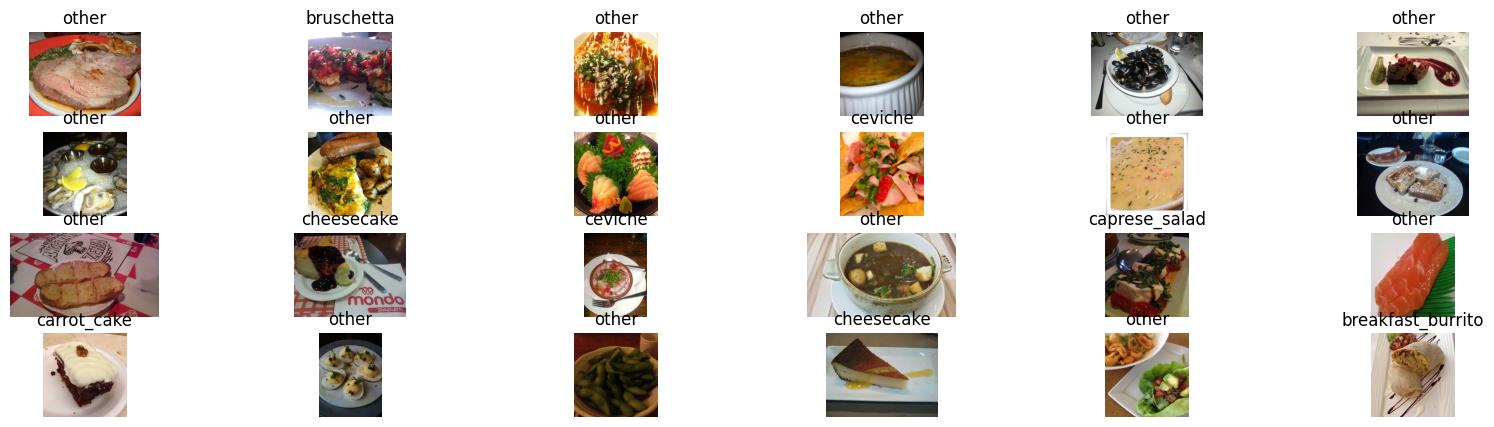

In [13]:
plt.figure(figsize=(20, 5))

num_rows = 4
num_cols = 6


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

## 3. Preparing the Data applying data augmentations,CUTout, Cutmix 

In [14]:
import torch
import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomRotation, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize

# Custom CutOut augmentation
class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if torch.rand(1).item() > self.p:
            return img

        h, w = img.size(-2), img.size(-1)
        y = torch.randint(0, h, (1,)).item()
        x = torch.randint(0, w, (1,)).item()

        y1 = max(0, y - self.mask_size // 2)
        y2 = min(h, y + self.mask_size // 2)
        x1 = max(0, x - self.mask_size // 2)
        x2 = min(w, x + self.mask_size // 2)

        img[:, y1:y2, x1:x2] = 0
        return img

# Enhanced data augmentation for training with additional transformations
train_transforms = transforms.Compose([
    RandomRotation(45),  # Increased rotation for variability
    RandomResizedCrop(224),
    RandomHorizontalFlip(p=0.7),  # Higher probability for horizontal flip
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET),  # AutoAugment for diverse transformations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # ColorJitter for varied lighting
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    CutOut(mask_size=20, p=0.5)  # CutOut for spatial masking
])

# Standard augmentation for testing
test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CutMix implementation for data augmentation within the training loop
def cutmix_data(x, y, alpha=1.0):
    """Applies CutMix augmentation to a batch of data."""
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    target_a = y
    target_b = y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    return x, target_a, target_b, lam

# Function to calculate random bounding box for CutMix
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


In [15]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Set model to training mode
    model.train()

    # Initialize training loss and accuracy
    train_loss, train_acc = 0, 0

    print("--> Training Progress")
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Transfer data to device
        images, labels = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(images)

        # Calculate loss and accumulate
        loss = loss_fn(y_pred, labels)
        train_loss += loss.item()

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Accuracy calculation
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item() / len(y_pred)

    # Average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


## 4. Creation of a DataLoader for the Dataset

In [16]:
class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder_21.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
train_dataset = Food21(train_imgs, transform=train_transforms)
test_dataset = Food21(test_imgs, transform=test_transforms)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=64)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=64)

# Testing the retrieval of a sample of images
for i in range(10):
    image = train_dataset.__getitem__(i)
    print(encoder_21.get_label(image[1]), image[0].shape)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


breakfast_burrito torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
cheesecake torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
apple_pie torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
cannoli torch.Size([3, 224, 224])


# 🤖 | Modeling

## 1. Gradient Checkpointing:

Saves GPU memory by recomputing intermediate values during backpropagation.
Implemented via the CheckpointedDenseNet class, applying checkpointing to the feature layers of DenseNet201.

## 2. Custom Classification Head:

The default classifier of DenseNet is replaced with a custom one:
Two fully connected layers (1920 → 1024 → 101).
An additional head to map the 101 outputs to 21 classes (Head class).

## 3. Pre-trained Weights:

Loads pre-trained weights (DenseNet201 trained on ImageNet).
Supports checkpoint recovery from a Kaggle directory or downloading from an external URL (commented out).

## 4. Mixed Precision Training:

Uses PyTorch’s GradScaler and autocast for efficient mixed precision training on GPUs, speeding up computation and reducing memory usage.

## 5. Data Parallelism:

Wraps the model with nn.DataParallel for multi-GPU training support.

## 6. Hyperparameters:

Optimizer: AdamW with a learning rate of 0.001.
Scheduler: ReduceLROnPlateau to reduce learning rate on a plateau in validation loss.
Loss Function: CrossEntropyLoss.
Seed Initialization:

## 7. Sets random seeds for reproducibility.
Training Loop:

Processes batches from train_loader on GPU, performs mixed precision training, and computes the loss.


## 8. Model Definition:

Initializes a DenseNet201 model.
Applies gradient checkpointing to save memory.
Replaces the classifier for specific task adaptation (Food-101 with 21 classes).
### 9. Weight Loading:

Loads weights from a specified checkpoint file.
### 10. Training Preparation:

Sets hyperparameters, optimizer, and scheduler.
Configures mixed precision training using GradScaler.

#### 11. Training Loop:

Performs forward pass using autocast for mixed precision.
Computes loss, backpropagates, and updates model weights.

### 12. GPU Compatibility:

Ensure that cuda is available and properly set up (torch.cuda.is_available()).

### 13. Checkpoint Loading:

Adjust strict=False when loading state dictionaries if the model structure differs slightly.


### 14. Integration:

Combine this with data loaders, validation, and testing loops for a complete training pipeline.
Potential Enhancements:

### 15. Add early stopping.
Experiment with learning rate schedules (e.g., cosine annealing with warm-up).
Use ensemble predictions for better accuracy.

This code is well-structured for tasks like Food-101 classification and can be customized further to align with specific requirements.

In [19]:
class Head(nn.Module):
    def __init__(self):
        super(Head, self).__init__()

        self.fc = nn.Linear(101, 21)
    
    def forward(self, x):
        return self.fc(x)

In [20]:
random_seeds = [42, 50, 2024]

for seed in random_seeds:
    print(f"Training with seed {seed}...")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


  


Training with seed 42...
Training with seed 50...
Training with seed 2024...


In [21]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.checkpoint import checkpoint
import torchinfo
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
import os

class CheckpointedDenseNet(nn.Module):
    def __init__(self, original_model):
        super(CheckpointedDenseNet, self).__init__()
        # Get feature layers and classifier from the original model
        self.features = original_model.features
        self.classifier = original_model.classifier

    def forward(self, x):
        # Apply checkpointing to feature layers to save memory
        x = checkpoint(self.features, x, use_reentrant=False)
        x = nn.functional.relu(x, inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the original model with pre-trained weights
weights = models.DenseNet201_Weights.IMAGENET1K_V1
original_model = models.densenet201(weights=weights)

# Wrap the original model with gradient checkpointing
model = CheckpointedDenseNet(original_model)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Define the additional classifier
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101)
)

# Replace the original classifier with the new classifier
model.classifier = classifier

# Check if the weights are available in the Kaggle input directory
checkpoint_path = "/kaggle/input/food-21-101/pytorch/default/1/food_classifier.pt"
if not os.path.exists(checkpoint_path):
   # # If not found, download from the external URL and save locally
   # import requests
   # url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"
  #  r = requests.get(url, allow_redirects=True)
    checkpoint_path = "/kaggle/working/food_classifier.pt"
    with open(checkpoint_path, "wb") as f:
        f.write(r.content)

# Load the pre-trained weights
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu', weights_only=True), strict=False)

# Additional classification head if needed
head = nn.Linear(101, 21)

# Combine model with head and wrap with DataParallel
model = nn.DataParallel(nn.Sequential(model, head))

# Summary of the model
torchinfo.summary(model, (1, 3, 224, 224))

# Hyperparameters
num_epochs = 30
lr = 1e-3

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Initialize GradScaler correctly for mixed precision training
scaler = GradScaler('cuda')

# Assume train_loader is already defined elsewhere in your code
# Training loop would use the corrected version of autocast
for images, labels in train_loader:
    images, labels = images.to('cuda'), labels.to('cuda')
    with torch.amp.autocast('cuda'):
        outputs = model(images)
        loss = loss_fn(outputs, labels)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 159MB/s]
/tmp/ipykernel_23/4040068502.py:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler('cuda')


#  🚂 | Training and Testing


## Training the Model

In [22]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [23]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [24]:
import torch
from torch.cuda.amp import autocast, GradScaler

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          history: dict = None):

    # Initialize the GradScaler for mixed-precision
    scaler = GradScaler()

    # Initialize history if not provided
    if history is None:
        history = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": [],
            'best_train_acc': (0, 0),
            "best_model": {}
        }

    # Training loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        model.train()  # Set model to training mode
        train_loss, train_acc = 0.0, 0.0

        # Training phase
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass with mixed-precision
            with autocast():
                outputs = model(images)
                loss = loss_fn(outputs, labels)

            # Backward pass with scaled gradients
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Accumulate loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += (predicted == labels).sum().item() / labels.size(0)

        # Average train loss and accuracy
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        # Validation phase
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print epoch results
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}\n"
              f"=============================\n")

        # Update history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        # Save the best model
        if test_acc > max(history["test_acc"], default=0):
            history["best_model"] = model.state_dict()

        # Scheduler step based on validation loss
        scheduler.step(test_loss)

        # Early stopping condition
        if test_acc > 0.98:
            print("Early stopping - Target accuracy reached.")
            break

    return model, history


In [25]:
model, history = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,  # Note that scheduler is also required based on your train function
    loss_fn=loss_fn,
    epochs=num_epochs,
    device=device,
    history=None  # Optional parameter
)
#model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device, history=None)

Epoch 1/30


/tmp/ipykernel_23/2451833217.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_23/2451833217.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


--> Testing Progress


100%|██████████| 198/198 [01:50<00:00,  1.79it/s]

Epoch: 1 | train_loss: 0.6508 | train_acc: 0.8533 | test_loss: 0.2104 | test_acc: 0.9340

Epoch 2/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 2 | train_loss: 0.4069 | train_acc: 0.8866 | test_loss: 0.1690 | test_acc: 0.9449

Epoch 3/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 3 | train_loss: 0.3931 | train_acc: 0.8900 | test_loss: 0.1760 | test_acc: 0.9430

Epoch 4/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.83it/s]

Epoch: 4 | train_loss: 0.3811 | train_acc: 0.8926 | test_loss: 0.1590 | test_acc: 0.9489

Epoch 5/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 5 | train_loss: 0.3726 | train_acc: 0.8953 | test_loss: 0.1479 | test_acc: 0.9535

Epoch 6/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.83it/s]

Epoch: 6 | train_loss: 0.3696 | train_acc: 0.8970 | test_loss: 0.1610 | test_acc: 0.9495

Epoch 7/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 7 | train_loss: 0.3687 | train_acc: 0.8958 | test_loss: 0.1577 | test_acc: 0.9508

Epoch 8/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 8 | train_loss: 0.3666 | train_acc: 0.8963 | test_loss: 0.1450 | test_acc: 0.9541

Epoch 9/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 9 | train_loss: 0.3606 | train_acc: 0.8978 | test_loss: 0.1413 | test_acc: 0.9555

Epoch 10/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 10 | train_loss: 0.3583 | train_acc: 0.8982 | test_loss: 0.1434 | test_acc: 0.9538

Epoch 11/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 11 | train_loss: 0.3502 | train_acc: 0.8993 | test_loss: 0.1374 | test_acc: 0.9569

Epoch 12/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.83it/s]

Epoch: 12 | train_loss: 0.3446 | train_acc: 0.9012 | test_loss: 0.1333 | test_acc: 0.9572

Epoch 13/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.83it/s]

Epoch: 13 | train_loss: 0.3455 | train_acc: 0.9002 | test_loss: 0.1418 | test_acc: 0.9547

Epoch 14/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 14 | train_loss: 0.3459 | train_acc: 0.9010 | test_loss: 0.1386 | test_acc: 0.9559

Epoch 15/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 15 | train_loss: 0.3427 | train_acc: 0.9027 | test_loss: 0.1373 | test_acc: 0.9546

Epoch 16/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 16 | train_loss: 0.3387 | train_acc: 0.9026 | test_loss: 0.1438 | test_acc: 0.9543

Epoch 17/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 17 | train_loss: 0.3161 | train_acc: 0.9089 | test_loss: 0.1255 | test_acc: 0.9597

Epoch 18/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 18 | train_loss: 0.3148 | train_acc: 0.9096 | test_loss: 0.1214 | test_acc: 0.9612

Epoch 19/30


--> Testing Progress


100%|██████████| 198/198 [01:50<00:00,  1.80it/s]

Epoch: 19 | train_loss: 0.3122 | train_acc: 0.9102 | test_loss: 0.1259 | test_acc: 0.9601

Epoch 20/30


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 20 | train_loss: 0.3129 | train_acc: 0.9089 | test_loss: 0.1232 | test_acc: 0.9602

Epoch 21/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 21 | train_loss: 0.3130 | train_acc: 0.9086 | test_loss: 0.1249 | test_acc: 0.9604

Epoch 22/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 22 | train_loss: 0.3065 | train_acc: 0.9121 | test_loss: 0.1246 | test_acc: 0.9608

Epoch 23/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 23 | train_loss: 0.2988 | train_acc: 0.9126 | test_loss: 0.1210 | test_acc: 0.9620

Epoch 24/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 24 | train_loss: 0.2969 | train_acc: 0.9133 | test_loss: 0.1153 | test_acc: 0.9634

Epoch 25/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.82it/s]

Epoch: 25 | train_loss: 0.2927 | train_acc: 0.9151 | test_loss: 0.1159 | test_acc: 0.9622

Epoch 26/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.82it/s]

Epoch: 26 | train_loss: 0.2943 | train_acc: 0.9135 | test_loss: 0.1169 | test_acc: 0.9622

Epoch 27/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 27 | train_loss: 0.2949 | train_acc: 0.9147 | test_loss: 0.1196 | test_acc: 0.9616

Epoch 28/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 28 | train_loss: 0.2941 | train_acc: 0.9133 | test_loss: 0.1193 | test_acc: 0.9613

Epoch 29/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 29 | train_loss: 0.2858 | train_acc: 0.9174 | test_loss: 0.1134 | test_acc: 0.9644

Epoch 30/30


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 30 | train_loss: 0.2841 | train_acc: 0.9167 | test_loss: 0.1120 | test_acc: 0.9641



In [26]:
model, history = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,  # Include scheduler if your train function requires it
    loss_fn=loss_fn,
    epochs=15,  # Setting to 15 epochs; you can adjust this as needed
    device=device,
    history=history  # Use `None` if it's the first run, or provide the existing history
)

Epoch 1/15


/tmp/ipykernel_23/2451833217.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_23/2451833217.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 1 | train_loss: 0.2863 | train_acc: 0.9164 | test_loss: 0.1122 | test_acc: 0.9649

Epoch 2/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 2 | train_loss: 0.2844 | train_acc: 0.9170 | test_loss: 0.1122 | test_acc: 0.9638

Epoch 3/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 3 | train_loss: 0.2845 | train_acc: 0.9167 | test_loss: 0.1134 | test_acc: 0.9647

Epoch 4/15


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 4 | train_loss: 0.2846 | train_acc: 0.9166 | test_loss: 0.1140 | test_acc: 0.9643

Epoch 5/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 5 | train_loss: 0.2796 | train_acc: 0.9186 | test_loss: 0.1103 | test_acc: 0.9656

Epoch 6/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 6 | train_loss: 0.2796 | train_acc: 0.9177 | test_loss: 0.1109 | test_acc: 0.9653

Epoch 7/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 7 | train_loss: 0.2736 | train_acc: 0.9193 | test_loss: 0.1103 | test_acc: 0.9646

Epoch 8/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 8 | train_loss: 0.2762 | train_acc: 0.9178 | test_loss: 0.1106 | test_acc: 0.9651

Epoch 9/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 9 | train_loss: 0.2738 | train_acc: 0.9198 | test_loss: 0.1118 | test_acc: 0.9650

Epoch 10/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 10 | train_loss: 0.2788 | train_acc: 0.9184 | test_loss: 0.1120 | test_acc: 0.9650

Epoch 11/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 11 | train_loss: 0.2753 | train_acc: 0.9193 | test_loss: 0.1114 | test_acc: 0.9649

Epoch 12/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 12 | train_loss: 0.2747 | train_acc: 0.9192 | test_loss: 0.1102 | test_acc: 0.9650

Epoch 13/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 13 | train_loss: 0.2710 | train_acc: 0.9200 | test_loss: 0.1104 | test_acc: 0.9645

Epoch 14/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 14 | train_loss: 0.2710 | train_acc: 0.9205 | test_loss: 0.1116 | test_acc: 0.9648

Epoch 15/15


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 15 | train_loss: 0.2761 | train_acc: 0.9188 | test_loss: 0.1108 | test_acc: 0.9651



In [27]:
model, history = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,  # Include scheduler if your train function requires it
    loss_fn=loss_fn,
    epochs=5,  # Setting to 15 epochs; you can adjust this as needed
    device=device,
    history=history  # Use `None` if it's the first run, or provide the existing history
)

Epoch 1/5


/tmp/ipykernel_23/2451833217.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_23/2451833217.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


--> Testing Progress


100%|██████████| 198/198 [01:50<00:00,  1.80it/s]

Epoch: 1 | train_loss: 0.2742 | train_acc: 0.9186 | test_loss: 0.1102 | test_acc: 0.9659

Epoch 2/5


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 2 | train_loss: 0.2699 | train_acc: 0.9210 | test_loss: 0.1103 | test_acc: 0.9653

Epoch 3/5


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.82it/s]

Epoch: 3 | train_loss: 0.2681 | train_acc: 0.9208 | test_loss: 0.1102 | test_acc: 0.9648

Epoch 4/5


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 4 | train_loss: 0.2707 | train_acc: 0.9209 | test_loss: 0.1101 | test_acc: 0.9649

Epoch 5/5


--> Testing Progress


100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

Epoch: 5 | train_loss: 0.2692 | train_acc: 0.9212 | test_loss: 0.1095 | test_acc: 0.9648



In [28]:
model, history = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,  # Include scheduler if your train function requires it
    loss_fn=loss_fn,
    epochs=3,  # Setting to 15 epochs; you can adjust this as needed
    device=device,
    history=history  # Use `None` if it's the first run, or provide the existing history
)

Epoch 1/3


/tmp/ipykernel_23/2451833217.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_23/2451833217.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 1 | train_loss: 0.2751 | train_acc: 0.9198 | test_loss: 0.1096 | test_acc: 0.9654

Epoch 2/3


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 2 | train_loss: 0.2726 | train_acc: 0.9205 | test_loss: 0.1103 | test_acc: 0.9653

Epoch 3/3


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.80it/s]

Epoch: 3 | train_loss: 0.2719 | train_acc: 0.9206 | test_loss: 0.1089 | test_acc: 0.9657



In [29]:
model, history = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,  # Include scheduler if your train function requires it
    loss_fn=loss_fn,
    epochs=1,  # Setting to 15 epochs; you can adjust this as needed
    device=device,
    history=history  # Use `None` if it's the first run, or provide the existing history
)

Epoch 1/1


/tmp/ipykernel_23/2451833217.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_23/2451833217.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


--> Testing Progress


100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

Epoch: 1 | train_loss: 0.2692 | train_acc: 0.9221 | test_loss: 0.1102 | test_acc: 0.9654



# 📋 | Result

## 1. Visualize AUC with Epochs

In [30]:
import matplotlib.pyplot as plt

def plot_history(history):
    loss = history['train_loss']
    accuracy = history['train_acc']
    val_loss = history['test_loss']
    val_accuracy = history['test_acc']
    x = range(len(loss))

    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#03045e', linewidth=2)
    if val_accuracy:
        plt.plot(x, val_accuracy, label='Validation acc', color='#48cae4', linewidth=2)
    if "best_train_acc" in history:
        best_epoch, best_acc = history["best_train_acc"]
        plt.scatter(best_epoch, best_acc, label='Best train acc', color='black', s=50)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#03045e', linewidth=2)
    if val_loss:
        plt.plot(x, val_loss, label='Validation loss', color='#48cae4', linewidth=2)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


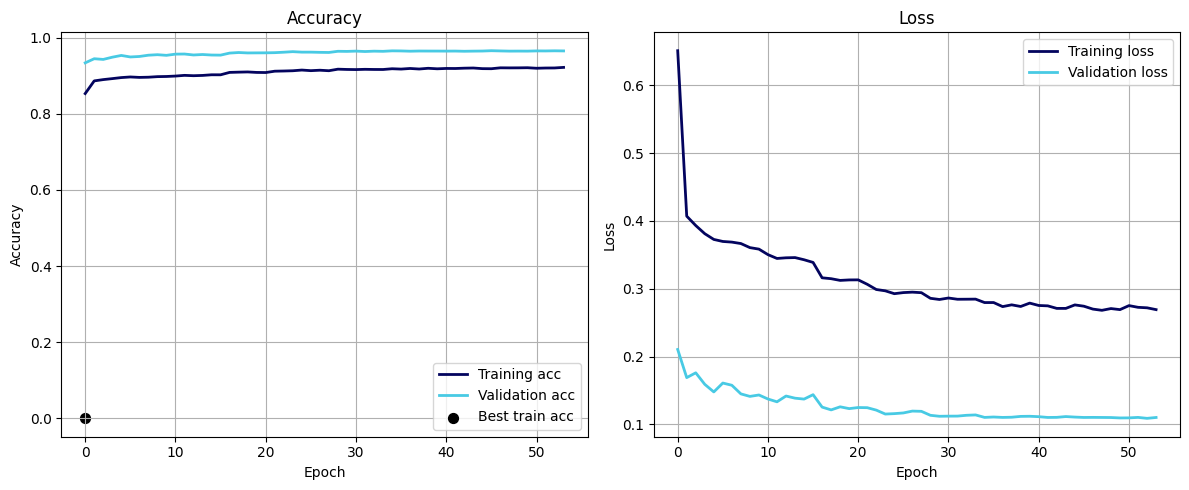

In [31]:

plot_history(history)


## 2. Assessing The Result

### Getting the Accuracy

In [32]:
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [33]:
evaluate(model,test_loader)

100%|██████████| 198/198 [01:49<00:00,  1.81it/s]

96.53465346534654


## 3. Build Testing Dataset

In [34]:
def visually_evaluate(model, data_df):
    num_rows = 3
    num_cols = 6

    random_idx = np.random.randint(0, data_df.shape[0], num_rows*num_cols)

    # Retrieve a number of images from the dataset.
    imgs, labels = data_df.iloc[random_idx], data_df.iloc[random_idx].label
    eval_dataset = Food21(imgs, transform=test_transforms)
    eval_loader = DataLoader(eval_dataset, batch_size=num_rows*num_cols, shuffle=False)
    eval_set = next(iter(eval_loader))

    # Get predictions from model.
    model.eval()
    preds = model(eval_set[0].to(device))
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)

    str_preds = []
    for idx in range(len(preds)):
        str_preds.append(encoder_21.get_label(preds[idx]))

    plt.figure(figsize=(20, 8))

    num_matches = 0
    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")

        img = plt.imread(imgs.path.iloc[idx])
        plt.imshow(img)

        title = str(labels.iloc[idx]) + " : " + str_preds[idx]
        title_obj = plt.title(title, fontdict={'fontsize':13})

        if labels.iloc[idx] == str_preds[idx]:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')

        acc = num_matches / (idx + 1)
    print("Prediction accuracy on test images: ", int(100 * acc) / 100)

    return


Prediction accuracy on test images:  0.94


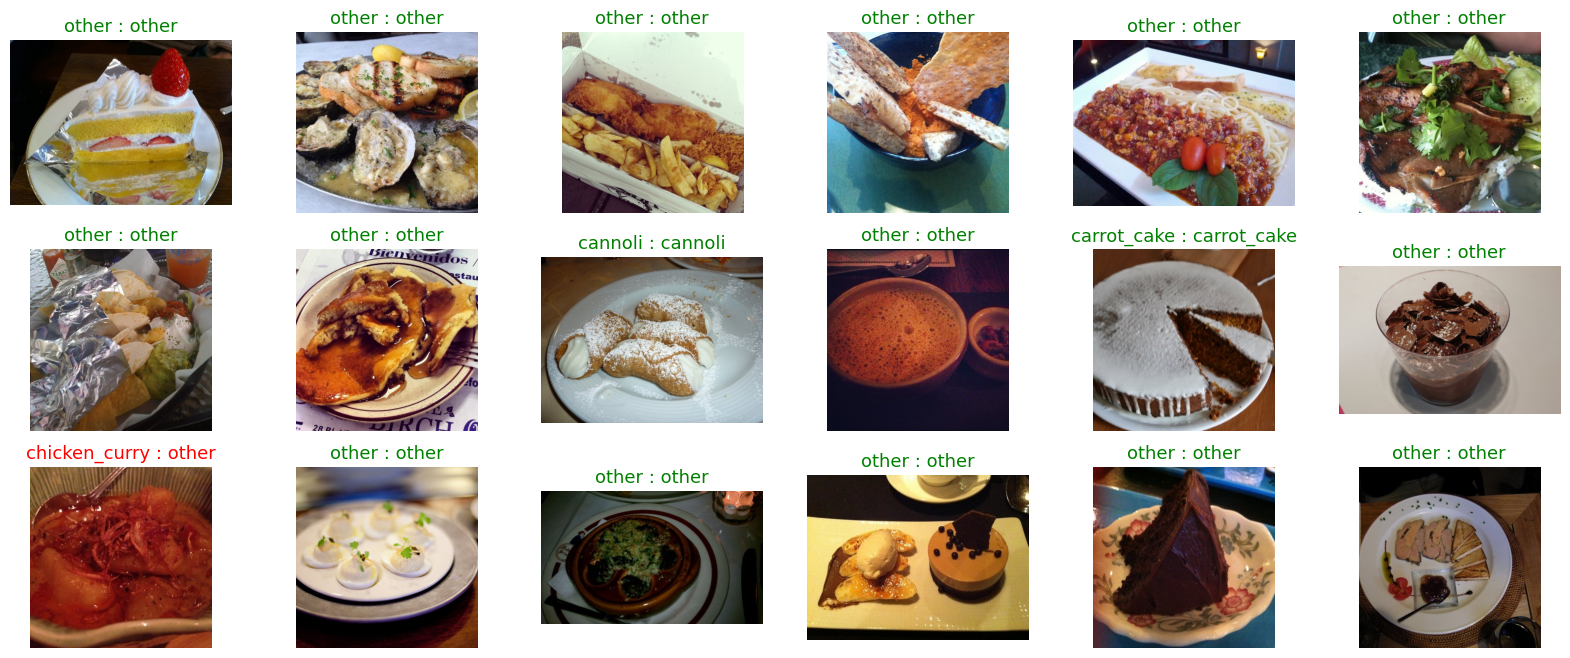

In [35]:
visually_evaluate(model, test_imgs)

## 4. Saving the model

In [36]:
import torch

# Define the path to save the model
model_save_path = '/kaggle/working/food_classifier.pt'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /kaggle/working/food_classifier.pt


### a. Load the Model



In [37]:

# Load the model
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode



/tmp/ipykernel_23/2614861499.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


DataParallel(
  (module): Sequential(
    (0): CheckpointedDenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _Den

### b. Run Inference
### c. Save Predictions

In [38]:
#Assume you have a test dataset and a DataLoader (test_loader). You can generate predictions as follows:


import pandas as pd

# Placeholder for predictions
predictions = []

# Iterate over test dataset
with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)  # Move images to the appropriate device
        outputs = model(images)  # Run inference
        _, preds = torch.max(outputs, 1)  # Get the class index
        predictions.extend(zip(image_ids, preds.cpu().numpy()))




# 📩 | Submission

## Submit on Kaggle
Navigate to the Kaggle Competition Page:

Go to the competition's "Submit Predictions" page.
Upload the Submission File:

Upload submission.csv (or equivalent file) that you generated in the previous step.
Wait for Evaluation:

Kaggle will evaluate your submission based on the test dataset and display your score on the leaderboard.
F. Best Practices
Verify Format: Ensure your submission.csv follows the exact format specified in the competition (e.g., column names, file structure).
Check IDs: Ensure the IDs in your submission file match the IDs in the test dataset.
Validate Locally: If possible, validate your predictions on a local hold-out set before submitting


In [39]:
# Create a DataFrame for submission
submission_df = pd.DataFrame(predictions, columns=['id', 'label'])

#Save the predictions to a CSV file following the submission format required by Kaggle:


submission_file_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_file_path, index=False)
print(f"Submission file saved to {submission_file_path}")

Submission file saved to /kaggle/working/submission.csv
